# Term Project - ECG/EKG Classification 
by Lewis Richter 


In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import plotly.express as px

from sklearn.model_selection import train_test_split

#from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPool1D, Flatten, BatchNormalization, LSTM

In [102]:
import datetime

# Define base directories
BASE_DIR = os.getcwd()  # Use current working directory
LOGS_DIR = os.path.join(BASE_DIR, "logs")  # For TensorBoard
MODELS_DIR = os.path.join(BASE_DIR, "models")  # For Saved Models

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def get_run_paths(dataset_name):
    """Creates unique paths for each dataset and run"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_path = os.path.join(LOGS_DIR, dataset_name, f"run_{timestamp}")
    model_path = os.path.join(MODELS_DIR, f"{dataset_name}_{timestamp}.keras")

    # Ensure log directories exist
    os.makedirs(log_path, exist_ok=True)

    return log_path, model_path

## Load Dataset

In [103]:
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset/mitbih_test.csv
dataset/ptbdb_abnormal.csv
dataset/ptbdb_normal.csv
dataset/mitbih_train.csv


In [104]:
test_data = pd.read_csv('dataset/mitbih_test.csv', header=None)   
test_data.dataframeName = 'mitbih_test.csv'
nRow, nCol = test_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 21892 rows and 188 columns


In [105]:
test_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
train_data = pd.read_csv('dataset/mitbih_train.csv', header=None)
train_data.dataframeName = 'mitbih_train.csv'
nRow, nCol = train_data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 87554 rows and 188 columns


In [107]:
train_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
print(f"train data size: {train_data.shape}")
print(f"test data size: {test_data.shape}")

train data size: (87554, 188)
test data size: (21892, 188)


## Preprocess Dataset


In [109]:
labels = {
    0: "Normal",
    1: "Supra-Ventricular",
    2: "Ventricular",
    3: "Fusion",
    4: "Unknown"
}

labels_abbreviation = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

value_counts_train = train_data.iloc[:,-1].value_counts().rename(labels)
value_counts_test = test_data.iloc[:,-1].value_counts().rename(labels)

value_counts_train_abbr = train_data.iloc[:,-1].value_counts().rename(labels_abbreviation)
value_counts_test_abbr = test_data.iloc[:,-1].value_counts().rename(labels_abbreviation)

In [110]:
# Plot the distribution of the labels in the train dataset using abbreviations
bar_fig = px.bar(x=value_counts_train_abbr.index,y=value_counts_train_abbr.values, title="The Count of Each Label in The Train Dataset", labels={"x": "Label", "y": "Count"}, text_auto=True)

bar_fig.update_layout(title_x=0.5, width=800, height=600)
bar_fig.show()

In [111]:
pie_fig = px.pie(names=value_counts_train.index, values=value_counts_train.values,
                 title="The Percentage of Each Label in The Train Dataset")

pie_fig.update_layout(title_x=0.5, width=800, height=600)
pie_fig.show()

In [112]:
# Plot the distribution of the labels in the train dataset using abbreviations
bar_fig = px.bar(x=value_counts_test_abbr.index,y=value_counts_test_abbr.values, title="The Count of Each Label in The Test Dataset", labels={"x": "Label", "y": "Count"}, text_auto=True)

bar_fig.update_layout(title_x=0.5, width=800, height=600)
bar_fig.show()

In [113]:
pie_fig = px.pie(names=value_counts_test.index, values=value_counts_test.values,
                    title="The Percentage of Each Label in The Test Dataset")

pie_fig.update_layout(title_x=0.5, width=800, height=600)
pie_fig.show()

In [114]:
n = random_index = np.random.randint(100)

ecg_0 = train_data.loc[train_data[187]==0, :].iloc[n,:187]
ecg_1 = train_data.loc[train_data[187]==1, :].iloc[n,:187]
ecg_2 = train_data.loc[train_data[187]==2, :].iloc[n,:187]
ecg_3 = train_data.loc[train_data[187]==3, :].iloc[n,:187]
ecg_4 = train_data.loc[train_data[187]==4, :].iloc[n,:187]

ecg_df = pd.DataFrame({'Normal': ecg_0,
                       'Supra-Ventricular': ecg_1,
                       'Ventricular': ecg_2,
                       'Fusion': ecg_3,
                       'Unknown': ecg_4})
ecg_plot = px.line(ecg_df,
                  labels={'index':'Time Intervals', 'value':'Amplitude (mV)', 'variable':'Categories'},
                  title="One ECG from Each Category")
ecg_plot.update_layout(title_x=0.25, width=1000, height=500)
ecg_plot.show()

In [115]:
x_train = train_data.iloc[:,:187] # Train Data
y_train= train_data.iloc[:,187] # Train Labels

x_test = test_data.iloc[:,:187] # Test Data
y_test = test_data.iloc[: ,187] # Test Labels

In [116]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (87554, 187)
y_train shape:  (87554,)
x_test shape:  (21892, 187)
y_test shape:  (21892,)


## Data Augmentation and Dataset Balancing

In [117]:
from collections import Counter
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Print the original class distribution
print("Original class distribution:", Counter(y_train))

# Step 2: Get class counts
class_counts = Counter(y_train)

# Step 3: Define target number of samples (50% of the majority class)
target_samples = int(class_counts[max(class_counts, key=class_counts.get)] * 0.5)  # Reduce majority class

# Step 4: Define undersampling strategy (reduce the majority class)
majority_class = max(class_counts, key=class_counts.get)
undersample_strategy = {majority_class: target_samples}

# Step 5: Apply undersampling (reduce normal beats)
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
x_under, y_under = undersampler.fit_resample(x_train, y_train)

# Step 6: Define oversampling strategy (only upsample minority classes that need it)
oversample_strategy = {cls: target_samples for cls in class_counts if cls != majority_class and class_counts[cls] < target_samples}

# Step 7: Apply oversampling (duplicate minority samples)
if oversample_strategy:  # Only apply oversampling if needed
    oversampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
    x_train_balanced, y_train_balanced = oversampler.fit_resample(x_under, y_under)
else:
    x_train_balanced, y_train_balanced = x_under, y_under

# Step 8: Print the final class distribution
print("Resampled class distribution:", Counter(y_train_balanced))

print('x_train_resampled shape: ', x_train_balanced.shape)
print('y_train_resampled shape: ', y_train_balanced.shape)

# Convert to DataFrame (assuming x_train is a Pandas DataFrame)
x_train_balanced = pd.DataFrame(x_train_balanced)  # Ensure it remains a DataFrame
y_train_balanced = pd.Series(y_train_balanced, name="label")  # Convert y_train back to a Series

train_df = pd.concat([x_train_balanced, y_train_balanced], axis=1)
print('train_df shape: ', train_df.shape)
print('x_train_resampled shape: ', x_train_balanced.shape)
print('y_train_resampled shape: ', y_train_balanced.shape)

train_df = pd.concat([x_train_balanced, y_train_balanced], axis=1)

print('train_df shape: ', train_df.shape)

Original class distribution: Counter({0.0: 72471, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})
Resampled class distribution: Counter({0.0: 36235, 1.0: 36235, 2.0: 36235, 3.0: 36235, 4.0: 36235})
x_train_resampled shape:  (181175, 187)
y_train_resampled shape:  (181175,)
train_df shape:  (181175, 188)
x_train_resampled shape:  (181175, 187)
y_train_resampled shape:  (181175,)
train_df shape:  (181175, 188)


In [118]:
value_counts_train = train_df.iloc[:,-1].value_counts().rename(labels)

value_counts_train_abbr = train_df.iloc[:,-1].value_counts().rename(labels_abbreviation)

In [119]:
# Plot the distribution of the labels in the train dataset using abbreviations
bar_fig = px.bar(x=value_counts_train_abbr.index,y=value_counts_train_abbr.values, title="The Count of Each Label After Balancing", labels={"x": "Label", "y": "Count"}, text_auto=True)

bar_fig.update_layout(title_x=0.5, width=800, height=600)
bar_fig.show()

In [120]:
pie_fig = px.pie(names=value_counts_train.index, values=value_counts_train.values,
                    title="The Percentage of Each Label After Balancing")

pie_fig.update_layout(title_x=0.5, width=800, height=600)
pie_fig.show()

In [121]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_df.iloc[:,:-1], train_df.iloc[:,-1], test_size=0.2, stratify=train_df.iloc[:,-1], random_state=42)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_test = test_data.iloc[:,:187] # Test Data
y_test = test_data.iloc[: ,187] # Test Labels

print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (144940, 187)
y_train shape:  (144940,)
x_val shape:  (36235, 187)
y_val shape:  (36235,)
x_test shape:  (21892, 187)
y_test shape:  (21892,)


In [122]:
# Print the class distribution
print("Training set class distribution train:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))


Training set class distribution train: Counter({3.0: 28988, 4.0: 28988, 1.0: 28988, 0.0: 28988, 2.0: 28988})
Validation set class distribution: Counter({3.0: 7247, 4.0: 7247, 2.0: 7247, 1.0: 7247, 0.0: 7247})
Test set class distribution: Counter({0.0: 18118, 4.0: 1608, 2.0: 1448, 1.0: 556, 3.0: 162})


## MLP Classification

https://www.kaggle.com/code/omarjfr/ecg-using-mlp

In [123]:
mlp_model = Sequential([
    Input(shape=(187,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.name = "MLP_Model"

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mlp_model.summary()

Model: "MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,565 (135.02 KB)

 Trainable params: 34,565 (135.02 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
log_path, model_path = get_run_paths(mlp_model.name)

earlystopping_cb = EarlyStopping(monitor='val_loss', patience=3)
modelcheckpoint_cb = ModelCheckpoint(model_path, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=log_path)

In [125]:
mlp_history = mlp_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[earlystopping_cb, modelcheckpoint_cb, tensorboard_cb],
)

Epoch 1/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7953 - loss: 0.5678 - val_accuracy: 0.9067 - val_loss: 0.2566
Epoch 2/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9188 - loss: 0.2274 - val_accuracy: 0.9395 - val_loss: 0.1723
Epoch 3/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9428 - loss: 0.1626 - val_accuracy: 0.9464 - val_loss: 0.1471
Epoch 4/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9566 - loss: 0.1250 - val_accuracy: 0.9636 - val_loss: 0.1093
Epoch 5/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9651 - loss: 0.1040 - val_accuracy: 0.9684 - val_loss: 0.0991
Epoch 6/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9706 - loss: 0.0867 - val_accuracy: 0.9736 - val_loss: 0.0870
Epoch 7/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9751 - loss: 0.0745 - val_accuracy: 0.9773 - val_loss: 0.0716
Epoch 8/20
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9787 - loss: 0.0634 - 

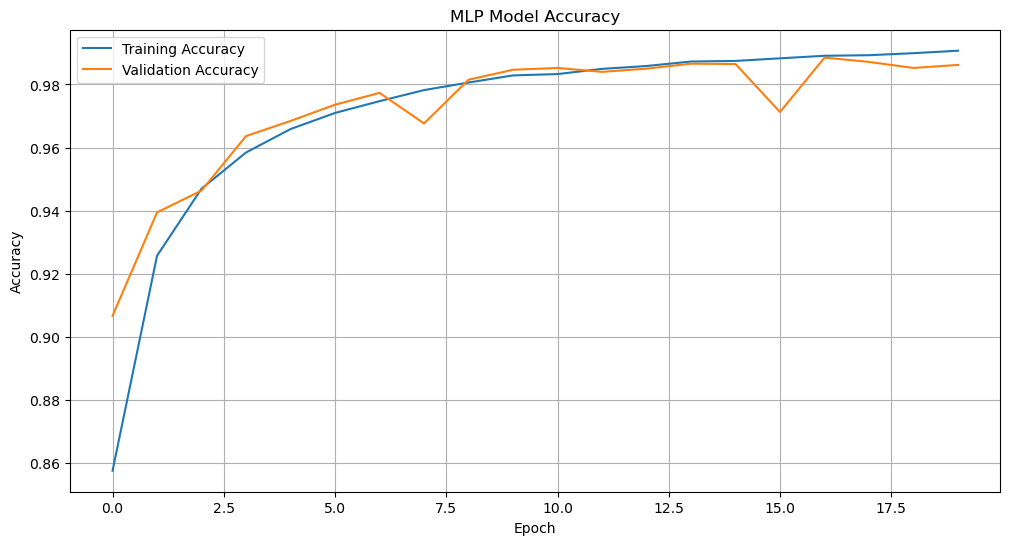

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

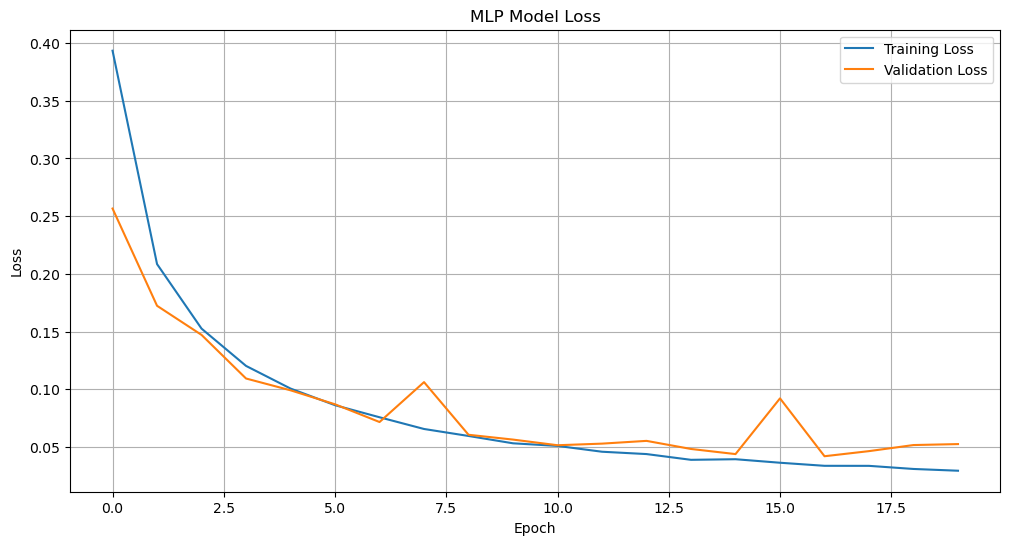

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [128]:
test_loss, test_accuracy = mlp_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred = np.argmax(mlp_model.predict(x_test), axis=1)

print(classification_report(y_test, y_pred, digits=4))

# Print accuracy, precision, recall and f1-scores
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("Weighted Precision: {:.2f}%".format(precision_score(y_test, y_pred, average='weighted') * 100))
print("Weighted Recall: {:.2f}%".format(recall_score(y_test, y_pred, average='weighted') * 100))
print("Weighted F1-score: {:.2f}%".format(f1_score(y_test, y_pred, average='weighted') * 100))

Test Accuracy: 0.95
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
              precision    recall  f1-score   support

         0.0     0.9936    0.9441    0.9682     18118
         1.0     0.4292    0.8507    0.5706       556
         2.0     0.8383    0.9593    0.8947      1448
         3.0     0.5378    0.8333    0.6538       162
         4.0     0.9514    0.9857    0.9682      1608

    accuracy                         0.9450     21892
   macro avg     0.7501    0.9146    0.8111     21892
weighted avg     0.9625    0.9450    0.9510     21892

Accuracy: 94.50%
Weighted Precision: 96.25%
Weighted Recall: 94.50%
Weighted F1-score: 95.10%


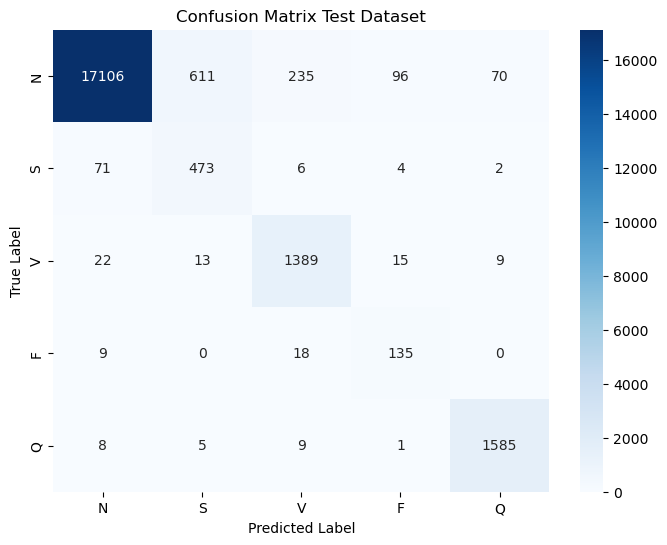

In [129]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset')
plt.show()

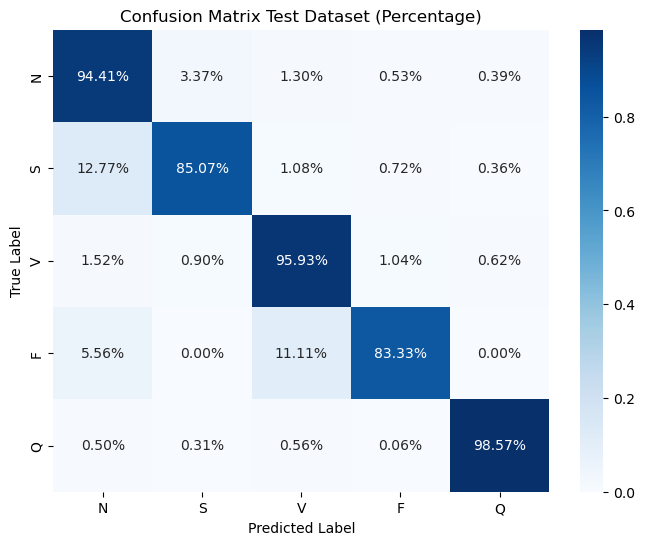

In [130]:
cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset (Percentage)')

plt.show()

## CNN Classifier

In [131]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_val = x_val.reshape(x_val.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)

print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

print(y_train[-1])
print(y_val[-1])
print(y_test[-1])

x_train shape:  (144940, 187, 1)
y_train shape:  (144940, 5)
x_val shape:  (36235, 187, 1)
y_val shape:  (36235, 5)
x_test shape:  (21892, 187, 1)
y_test shape:  (21892, 5)
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]


### Basic CNN (Iteration 1)

In [132]:
cnn_model = Sequential([
    Input(shape=(187, 1)),
    Conv1D(32, kernel_size=5, activation='relu'),
    MaxPool1D(2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPool1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

cnn_model.name = "CNN_Model"

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 183, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 91, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 87, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2752)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       352,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,381 (1.42 MB)

 Trainable params: 373,381 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
log_path, model_path = get_run_paths(cnn_model.name)

earlystopping_cb = EarlyStopping(monitor='val_loss', patience=5)
modelcheckpoint_cb = ModelCheckpoint(model_path, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=log_path)
ReduceLROnPlateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=10, min_lr=1e-6)

callbacks = [earlystopping_cb, modelcheckpoint_cb, tensorboard_cb, ReduceLROnPlateau_cb]

In [134]:
cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.8483 - loss: 0.4157 - val_accuracy: 0.9619 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9694 - loss: 0.0889 - val_accuracy: 0.9763 - val_loss: 0.0698 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.9839 - loss: 0.0510 - val_accuracy: 0.9856 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9885 - loss: 0.0355 - val_accuracy: 0.9890 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9918 - loss: 0.0262 - val_accuracy: 0.9933 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.9937 - loss: 0.0205 - val_accuracy: 0.9937 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9

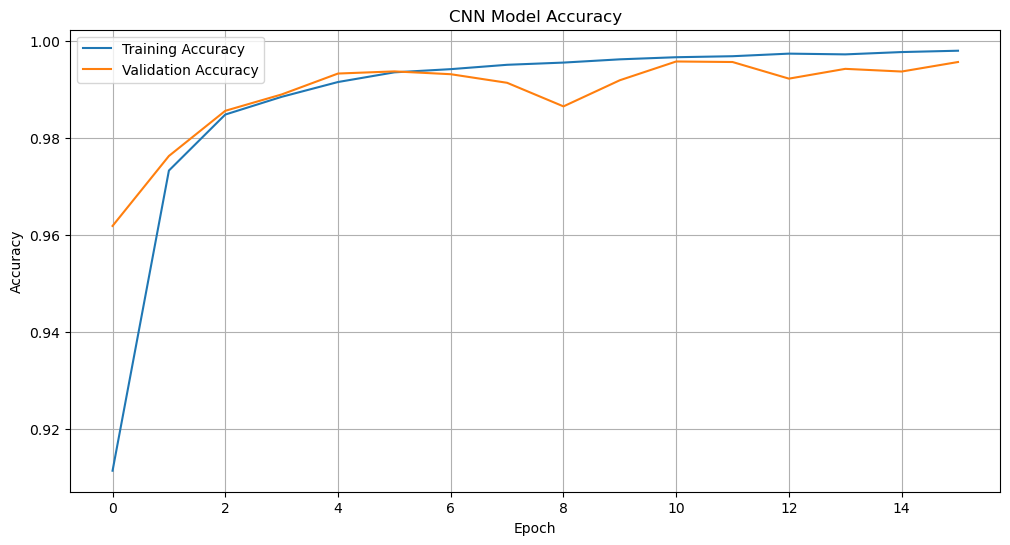

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

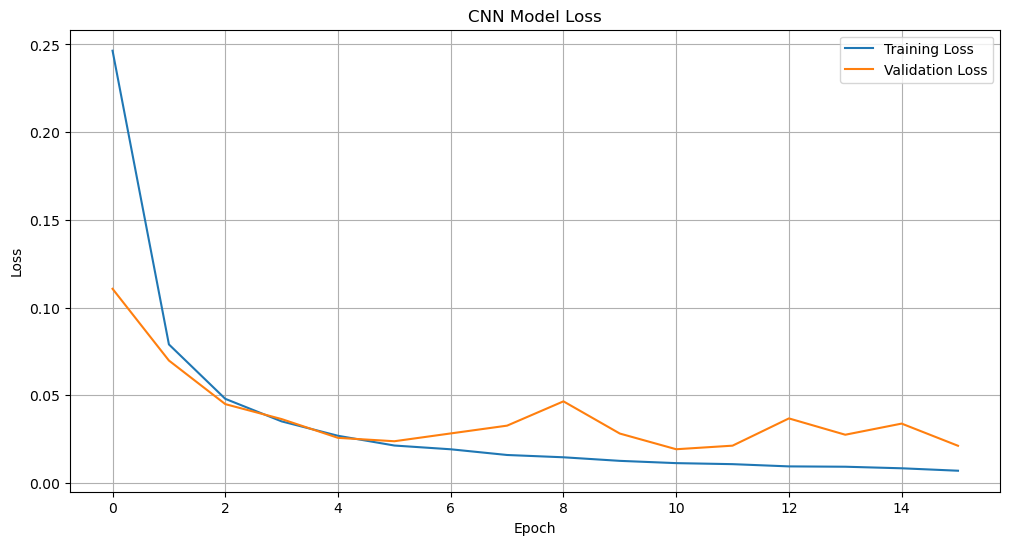

In [136]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [137]:
y_pred = np.argmax(cnn_model.predict(x_test), axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred, digits=4))

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0     0.9922    0.9821    0.9871     18118
           1     0.7042    0.8219    0.7585       556
           2     0.9243    0.9530    0.9385      1448
           3     0.7043    0.8086    0.7529       162
           4     0.9755    0.9900    0.9827      1608

    accuracy                         0.9754     21892
   macro avg     0.8601    0.9111    0.8839     21892
weighted avg     0.9771    0.9754    0.9760     21892



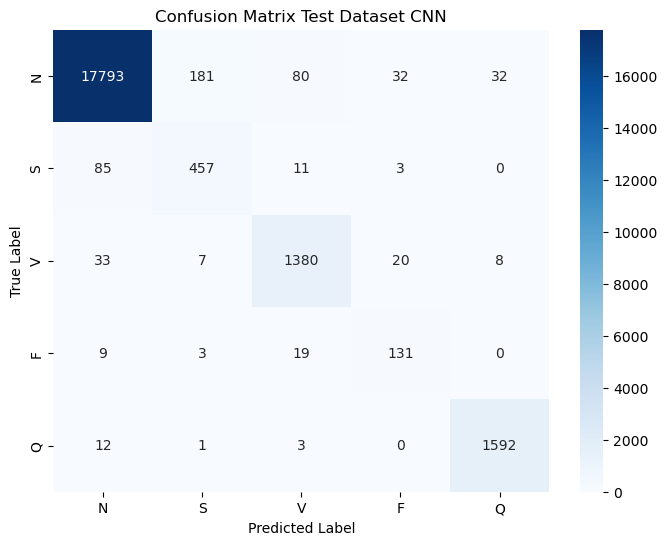

In [138]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset CNN')
plt.show()

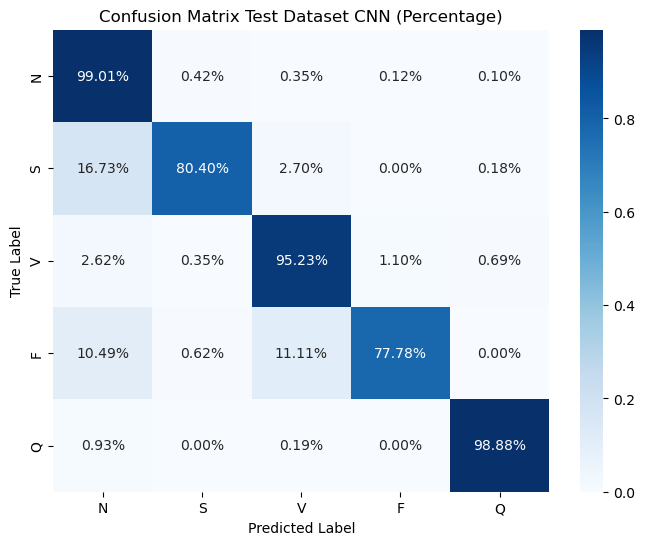

In [50]:
cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset CNN (Percentage)')
plt.show()


### more Complex CNN (Iteration 2)

In [ ]:
cnn_model_it2 = Sequential([
    Input(shape=(187, 1)),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPool1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPool1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # 5 output classes
])

cnn_model_it2.name = "CNN_Model-Iteration2"

cnn_model_it2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model_it2.summary()


In [ ]:
log_path, model_path = get_run_paths(cnn_model.name)

earlystopping_cb = EarlyStopping(monitor='val_loss', patience=5)
modelcheckpoint_cb = ModelCheckpoint(model_path, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=log_path)
ReduceLROnPlateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=10, min_lr=1e-6)

callbacks = [earlystopping_cb, modelcheckpoint_cb, tensorboard_cb, ReduceLROnPlateau_cb]

In [ ]:
cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=callbacks,
)

## CNN + LSTM Model
https://www.kaggle.com/code/behrouzmirabdi/ecg-classification-cnn-lstm-acc-98

In [51]:
cnn_lstm_model = Sequential([
    Input(shape=(187, 1)),

    Conv1D(64, kernel_size=6, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding='same'),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding='same'),

    LSTM(64, return_sequences=True, activation='tanh'),
    LSTM(32, activation='tanh'),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    
    Dense(5, activation='softmax')
])

cnn_lstm_model.name = "CNN_LSTM_Model"

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()

Model: "CNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 182, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 182, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 89, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 89, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 43, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 22, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,717 (295.77 KB)

 Trainable params: 75,333 (294.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [52]:
log_path, model_path = get_run_paths(cnn_lstm_model.name)

earlystopping_cb = EarlyStopping(monitor='val_loss', patience=5)
modelcheckpoint_cb = ModelCheckpoint(model_path, save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=log_path)
ReduceLROnPlateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=20, cooldown=20, min_lr=1e-6)

callbacks = [earlystopping_cb, modelcheckpoint_cb, tensorboard_cb, ReduceLROnPlateau_cb]

In [53]:
cnn_lstm_history = cnn_lstm_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 7709s 851ms/step - accuracy: 0.8805 - loss: 0.3264 - val_accuracy: 0.9700 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 2/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 850s 94ms/step - accuracy: 0.9748 - loss: 0.0752 - val_accuracy: 0.9867 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 3/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 409s 45ms/step - accuracy: 0.9854 - loss: 0.0453 - val_accuracy: 0.9859 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 4/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 686s 76ms/step - accuracy: 0.9890 - loss: 0.0358 - val_accuracy: 0.9898 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 5/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 228s 25ms/step - accuracy: 0.9914 - loss: 0.0279 - val_accuracy: 0.9809 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 6/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step - accuracy: 0.9928 - loss: 0.0233 - val_accuracy: 0.9920 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 7/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 202s 22ms/step

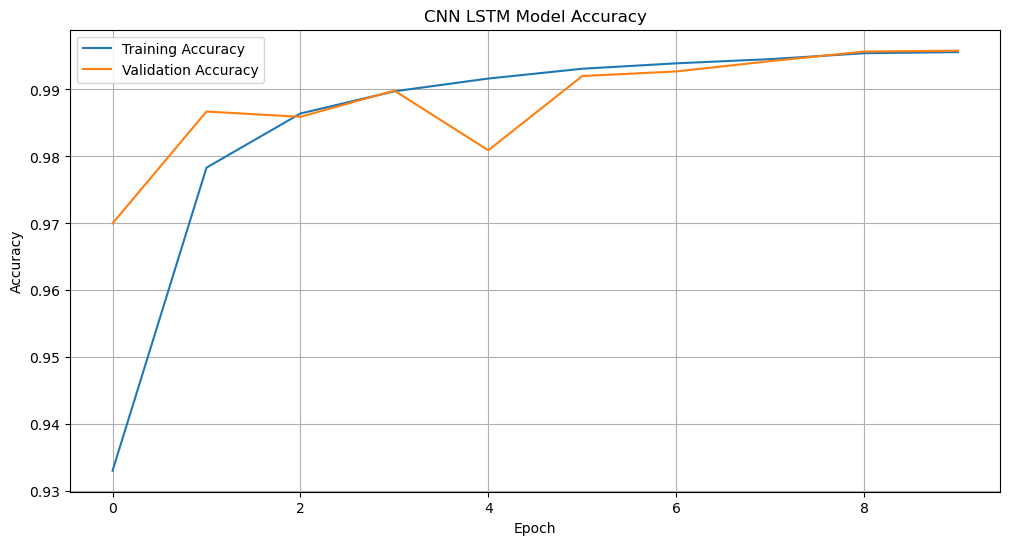

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

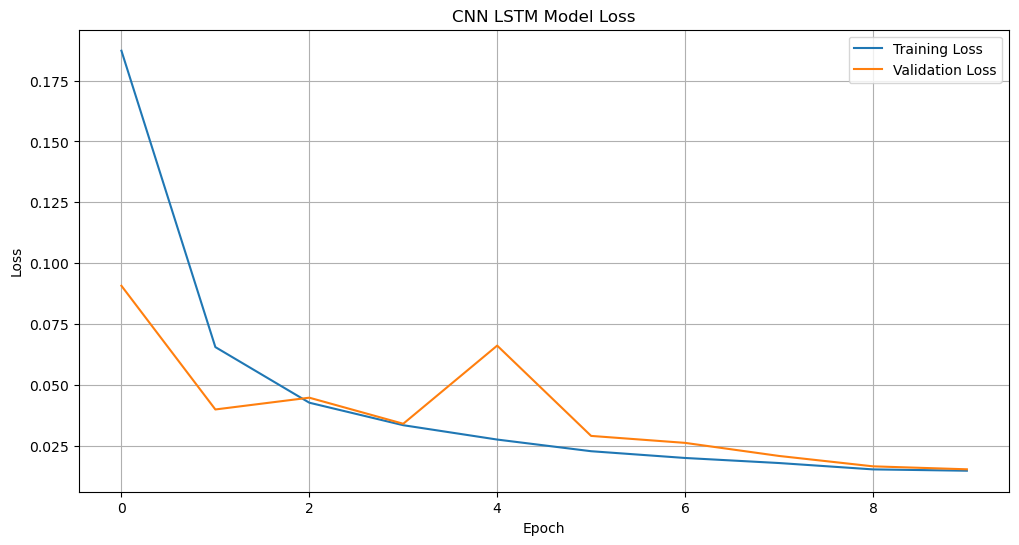

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(cnn_lstm_history.history['loss'], label='Training Loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('CNN LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [58]:
y_pred = np.argmax(cnn_lstm_model.predict(x_test), axis=1)
#y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred))

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.76      0.86      0.81       556
           2       0.93      0.97      0.95      1448
           3       0.71      0.86      0.78       162
           4       0.98      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.87      0.93      0.90     21892
weighted avg       0.98      0.98      0.98     21892



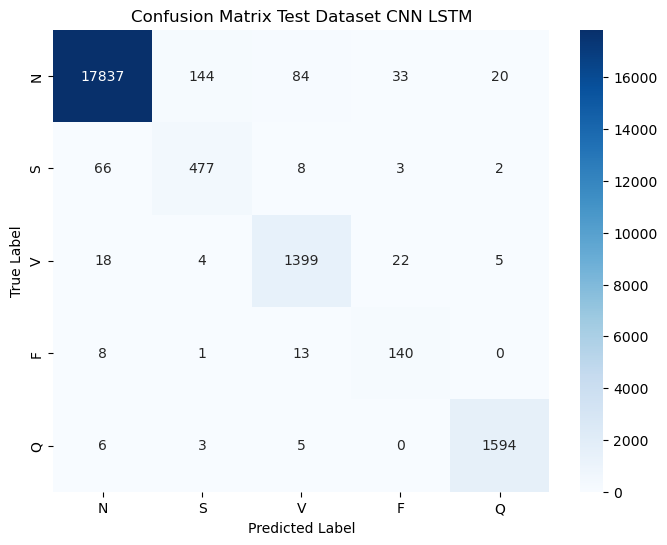

In [59]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset CNN LSTM')
plt.show()

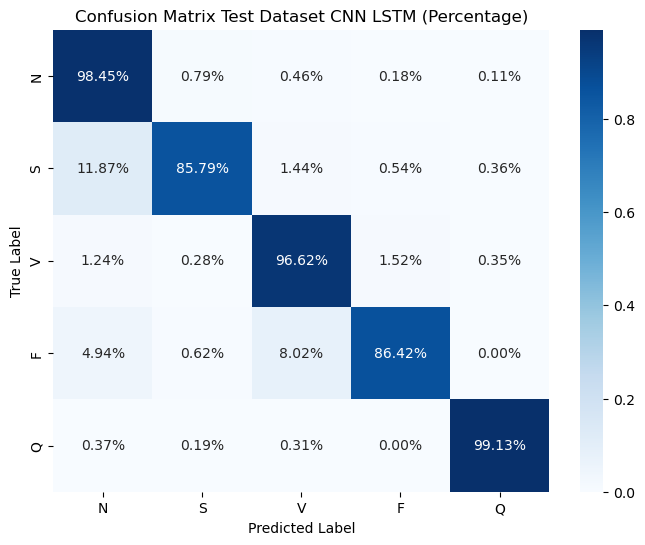

In [60]:
cm = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels_abbreviation.values(), yticklabels=labels_abbreviation.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test Dataset CNN LSTM (Percentage)')
plt.show()